Loaded 28182 samples with 33 unique classes.
Train: 600 samples, Validation: 200 samples, Test: 200 samples
Epoch 0, Train Loss: 2.2139, Val Loss: 1.1525, Train Acc: 0.8533, Val Acc: 0.8550
Epoch 10, Train Loss: 0.1338, Val Loss: 0.0946, Train Acc: 0.9733, Val Acc: 0.9900
Epoch 20, Train Loss: 0.0628, Val Loss: 0.0481, Train Acc: 0.9883, Val Acc: 0.9900
Epoch 30, Train Loss: 0.0385, Val Loss: 0.0290, Train Acc: 0.9933, Val Acc: 0.9950
Epoch 40, Train Loss: 0.0261, Val Loss: 0.0208, Train Acc: 0.9967, Val Acc: 0.9950
Epoch 50, Train Loss: 0.0184, Val Loss: 0.0165, Train Acc: 1.0000, Val Acc: 1.0000
Epoch 60, Train Loss: 0.0146, Val Loss: 0.0142, Train Acc: 1.0000, Val Acc: 0.9950
Epoch 70, Train Loss: 0.0110, Val Loss: 0.0132, Train Acc: 1.0000, Val Acc: 0.9950
Epoch 80, Train Loss: 0.0091, Val Loss: 0.0117, Train Acc: 1.0000, Val Acc: 0.9950
Epoch 90, Train Loss: 0.0077, Val Loss: 0.0104, Train Acc: 1.0000, Val Acc: 0.9950

Classification Report (Test set):
              precision    r

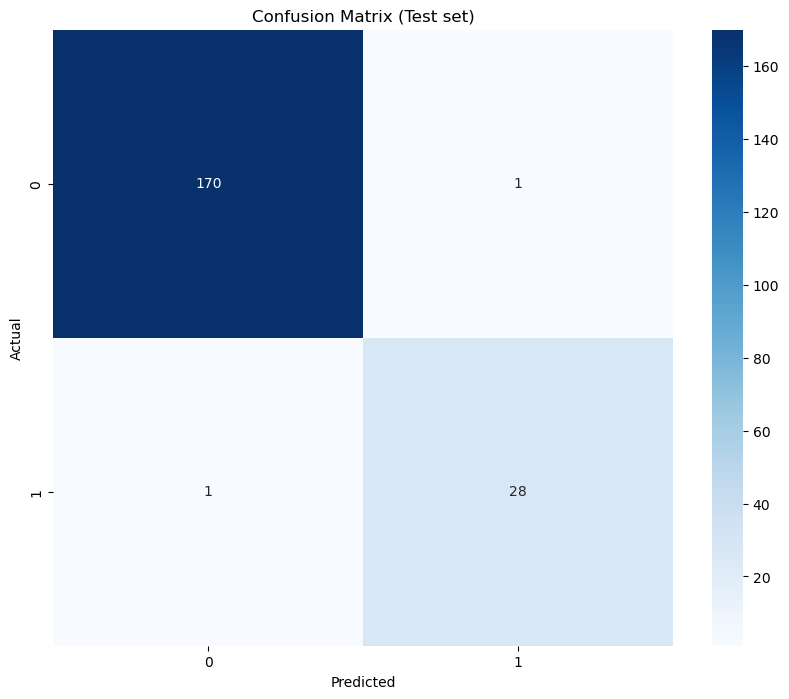

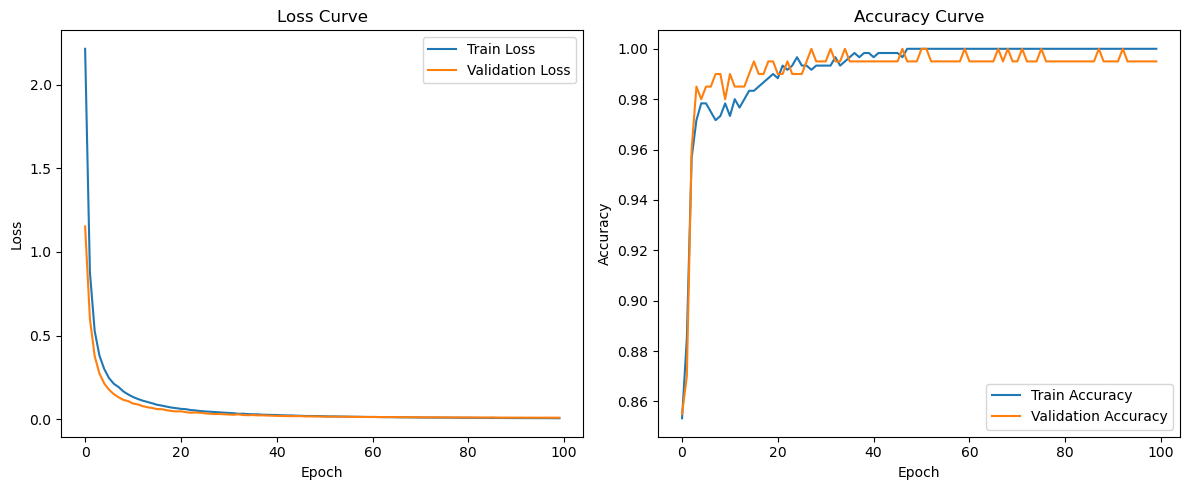

In [4]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Activation functions
def relu(x):
    """ 
    ReLU activation: max(0, x)
    """
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """
    Derivative of ReLU: 1 if x > 0, else 0
    """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    """
    Softmax activation: exp(x) / sum(exp(x))
    """
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Numerical stability
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0,1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1 per sample"
    return result
class MulticlassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):  # ✅ Correct: __init__
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        # Initialisation des poids et biais
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        self.z_values = []
        self.activations = [X]
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            self.activations.append(relu(z))
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        output = softmax(z)
        self.activations.append(output)
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.sum(y_true * np.log(y_pred)) / m
        return loss

    def compute_accuracy(self, y_true, y_pred):
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
        accuracy = np.mean(y_true_labels == y_pred_labels)
        return accuracy

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y  # Pour softmax + cross-entropy
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = (dZ @ self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        # L2 regularization et mise à jour
        l2_lambda = 0.01
        for i in range(len(self.weights)):
            self.d_weights[i] += (l2_lambda / m) * self.weights[i]
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        outputs = self.forward(X)
        return np.argmax(outputs, axis=1)
# Load and preprocess data
data_dir = r"C:\Users\HP\Desktop\Master S2\amhcd-data-64"
labels_file = os.path.join(data_dir, "labels-map.csv")

# Verify that the labels file exists
if not os.path.exists(labels_file):
    raise FileNotFoundError(f"Labels file not found at: {labels_file}. Ensure 'amhcd-data-64.zip' is extracted to {data_dir}.")

labels_df = pd.read_csv(labels_file, header=None, names=['image_path', 'label'], sep=',')
if labels_df.empty:
    raise ValueError("No data loaded from labels-map.csv. Check file content and format.")
print(f"Loaded {len(labels_df)} samples with {labels_df['label'].nunique()} unique classes.")
# Clean image paths
labels_df["image_path"] = labels_df["image_path"].str.replace("images-data-64/", "", regex=False)
labels_df["image_path"] = labels_df["image_path"].apply(lambda x: os.path.normpath(x))
labels_df["image_path"] = labels_df["image_path"].apply(lambda x: os.path.join(data_dir, x))
# Encode labels
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)
def load_and_preprocess_image(image_path, target_size=(32, 32), max_warnings=10):
    full_path = os.path.join(data_dir, image_path)
    if not os.path.exists(full_path):
        if load_and_preprocess_image.warning_count < max_warnings:
            print(f"Warning: Image not found at {full_path}. Skipping.")
            load_and_preprocess_image.warning_count += 1
        if load_and_preprocess_image.warning_count == max_warnings:
            print(f"Reached {max_warnings} warnings, suppressing further output.")
        return None
    img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        if load_and_preprocess_image.warning_count < max_warnings:
            print(f"Warning: Failed to load image at {full_path}. Skipping.")
            load_and_preprocess_image.warning_count += 1
        if load_and_preprocess_image.warning_count == max_warnings:
            print(f"Reached {max_warnings} warnings, suppressing further output.")
        return None
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalization
    return img.flatten()
load_and_preprocess_image.warning_count = 0
# Load a subset of images for testing
images = []
valid_labels = []
#max_images =  1000
for path, label in zip(labels_df['image_path'][:max_images], labels_df['label_encoded'][:]):
    img = load_and_preprocess_image(path)
    if img is not None:
        images.append(img)
        valid_labels.append(label)

if not images:
    raise ValueError("No valid images were loaded. Check image paths and files.")

X = np.array(images)
y = np.array(valid_labels)

if X.shape[0] != y.shape[0]:
    raise ValueError(f"Mismatch between number of images ({X.shape[0]}) and labels ({y.shape[0]})")
if X.shape[1] != 32 * 32:
    raise ValueError(f"Expected flattened image size of {32 * 32}, got {X.shape[1]}")

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# Convert to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

if X_train.shape[0] + X_val.shape[0] + X_test.shape[0] != X.shape[0]:
    raise ValueError("Train-val-test split sizes must sum to total samples")
print(f"Train: {X_train.shape[0]} samples, Validation: {X_val.shape[0]} samples, Test: {X_test.shape[0]} samples")
# One-hot encode labels

one_hot_encoder = OneHotEncoder(categories=[np.arange(num_classes)], sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))
# Create and train the model
layer_sizes = [X_train.shape[1], 64, 32, num_classes]  # 1024-64-32-num_classes
nn = MulticlassNeuralNetwork(layer_sizes, learning_rate=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100, batch_size=32
)
# Predictions and evaluation
y_pred = nn.predict(X_test)
print("\nClassification Report (Test set):")
print(classification_report(
    y_test, y_pred,
    labels=np.arange(num_classes),
    target_names=label_encoder.classes_,
    zero_division=0
))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()
# Loss and accuracy curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_plot.png')
plt.show()
plt.close()

           
